# Clustering (&PCA with Bootsrap)

In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import scipy.stats
!pip install plotly-express
!pip install kneed


import plotly.express as px
from kneed import KneeLocator
from sklearn.datasets import make_blobs, make_moons
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
import scipy.cluster.hierarchy as sch
import seaborn as sns
import seaborn as sn

#for bootstrap
from tqdm import tqdm
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

#for logistics model and classification
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, classification_report, accuracy_score, roc_auc_score

In [42]:
data = pd.read_excel("Our_data.xlsx") #читаем файл
data.head() #печатаем результат

company_name  world_rank_2022  world_rank_2021  world_rank_2020  \
0              NETFLIX             44.0             37.0             65.0   
1  ABBOTT LABORATORIES             43.0             48.0             57.0   
2              PEPSICO             42.0             51.0             43.0   
3  CHEVRON CORPORATION             41.0             66.0             33.0   
4                ADOBE             40.0             29.0             52.0   

   local_rank_2022  local_rank_2021  local_rank_2020  founded_year  \
0             30.0             23.0             39.0        1997.0   
1             29.0             32.0             35.0        1888.0   
2             28.0             28.0             28.0        1898.0   
3             27.0             42.0             23.0        1879.0   
4             26.0             21.0             32.0        1982.0   

   country_us  company_age  ...  net_income_2021 net_income_2022  \
0           1         26.0  ...         5.116228        4.491924   
1           1        135.0  ...            7.071           6.933   
2           1        125.0  ...            7.618            8.91   
3           1        144.0  ...           15.625          35.465   
4           1         41.0  ...            4.822           4.756   

  net_income_avg currency total_articles num_employees  \
0       4.070609      USD            NaN       12800.0   
1       6.162200      USD            NaN      115000.0   
2       8.004800      USD            8.0      315000.0   
3      18.057300      USD            4.0       43846.0   
4       4.696146      USD           10.0       29239.0   

               use_cases_1             use_cases_2 status  \
0                      NaN                     NaN      0   
1                      NaN                     NaN      0   
2               NFT&Gaming         Smart_contracts      1   
3          Smart_contracts  Logistics&Supply_chain      1   
4  Data_managment&Security                     NaN      1   

                      industry  
0  Communication&Entertainment  
1                   Healthcare  
2             Food&Restaurants  
3          Resources&Materials  
4                  IT&Software  

[5 rows x 59 columns]

In [43]:
data.columns

Index(['company_name', 'world_rank_2022', 'world_rank_2021', 'world_rank_2020',
       'local_rank_2022', 'local_rank_2021', 'local_rank_2020', 'founded_year',
       'country_us', 'company_age', 'ipo_year', 'matched_to',
       'total_equity_2019', 'total_equity_2020', 'total_equity_2021',
       'total_equity_2022', 'total_equity_avg', 'total_capitalization_2019',
       'total_capitalization_2020', 'total_capitalization_2021',
       'total_capitalization_2022', 'total_cap_avg', 'total_liabilities_2019',
       'total_liabilities_2020', 'total_liabilities_2021',
       'total_liabilities_2022', 'total_liab_avg', 'total_revenue_2019',
       'total_revenue_2020', 'total_revenue_2021', 'total_revenue_2022',
       'total_rev_avg', 'investing_cashflow_2019', 'investing_cashflow_2020',
       'investing_cashflow_2021', 'investing_cashflow_2022',
       'invest_cashflow_avg', 'basic_eps_2019', 'basic_eps_2020',
       'basic_eps_2021', 'basic_eps_2022', 'basic_eps_avg',
       'total_ass

In [44]:
df=data[['company_name','country_us',
 'company_age',
 'total_equity_avg',
 'total_cap_avg',
 'total_rev_avg',
 'invest_cashflow_avg',
 'basic_eps_avg',
 'net_income_avg',
 'num_employees','use_cases_1',
 'use_cases_2',
 'status',
 'industry']]

In [45]:
df['company_age'] = df['company_age'].astype('Int64')
df['num_employees'] = df['num_employees'].astype('Int64')
df['country_us'] = df['country_us'].astype('Int64')
df['status'] = df['status'].astype('Int64')
df[['total_equity_avg',
 'total_cap_avg',
 'total_rev_avg',
 'invest_cashflow_avg',
 'basic_eps_avg',
 'net_income_avg']] = df[['total_equity_avg',
 'total_cap_avg',
 'total_rev_avg',
 'invest_cashflow_avg',
 'basic_eps_avg',
 'net_income_avg']].astype(float)

<ipython-input-45-0d8b0726db25>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['company_age'] = df['company_age'].astype('Int64')
<ipython-input-45-0d8b0726db25>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['num_employees'] = df['num_employees'].astype('Int64')
<ipython-input-45-0d8b0726db25>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.p

## Correlation and first sight on data

<ipython-input-46-ece013035d78>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr().round(2)


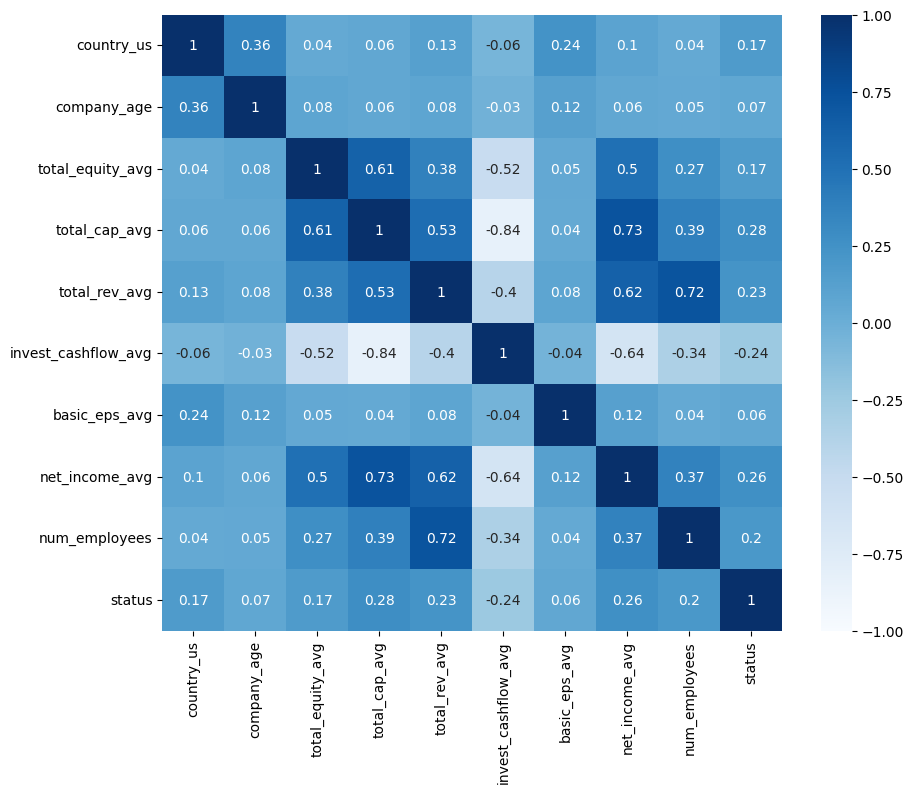

In [46]:
corr = df.corr().round(2)

plt.figure(figsize=(10, 8))

sns.heatmap(corr, vmin=-1, vmax=1, annot=True, cmap=plt.cm.Blues)
plt.show()

In [47]:
df.describe().T

count          mean           std       min       25%  \
country_us           2000.0           0.5      0.500125       0.0       0.0   
company_age          1342.0     50.204918     44.204398       1.0      22.0   
total_equity_avg     1546.0     11.930748     48.895331   -15.238  1.384331   
total_cap_avg        1546.0     18.538035     53.382663 -3.467891  1.853012   
total_rev_avg        1544.0     14.357424     35.848806 -0.203345  1.439124   
invest_cashflow_avg  1543.0     -2.101509      8.583899 -151.7145  -1.28952   
basic_eps_avg        1542.0      2.329692      8.718527 -181.6856  0.073679   
net_income_avg       1546.0      1.392671        4.6699   -7.0357  0.119754   
num_employees        1593.0  34183.434401  89657.607303       8.0    4448.0   
status               2000.0          0.09      0.286253       0.0       0.0   

                          50%        75%         max  
country_us                0.5        1.0         1.0  
company_age              31.0       63.0       450.0  
total_equity_avg     3.366556   8.660173  1481.01399  
total_cap_avg        5.227469   14.36931    693.8846  
total_rev_avg        4.181791  12.177905    501.6397  
invest_cashflow_avg -0.413261  -0.121463   19.255792  
basic_eps_avg        0.306797      3.018  155.808333  
net_income_avg       0.383779     1.0335      85.333  
num_employees         11310.0    27441.0   2100000.0  
status                    0.0        0.0         1.0

## CLUSTERING

## K-means

In [48]:
df_main=df[['company_age','country_us',
 'total_equity_avg',
 'total_cap_avg',
 'total_rev_avg',
 'invest_cashflow_avg',
 'basic_eps_avg',
 'net_income_avg',
 'num_employees',
 'status']]

In [49]:
#заполняем пропуски медиальными значениями
features1 = df_main
features1=features1.fillna(features1['company_age'].median())
features1=features1.fillna(features1['total_cap_avg'].median())
features1=features1.fillna(features1['total_rev_avg'].median())
features1=features1.fillna(features1['invest_cashflow_avg'].median())
features1=features1.fillna(features1['basic_eps_avg'].median())
features1=features1.fillna(features1['net_income_avg'].median())
features1=features1.fillna(features1['num_employees'].median())

In [53]:
#стандартизация данных
scaled_features1 = StandardScaler().fit_transform(features1)
scaled_features1

array([[-0.47947765,  1.        , -0.00508954, ..., -0.30947499,
        -0.17782893, -0.31448545],
       [ 2.4424503 ,  1.        ,  0.43559668, ..., -0.14936937,
         1.08134068, -0.31448545],
       [ 2.17438352,  1.        , -0.00704095, ..., -0.00832337,
         3.54546907,  3.17979734],
       ...,
       [-0.34544426, -1.        , -0.3605268 , ..., -0.61885215,
        -0.32662532, -0.31448545],
       [-0.34544426, -1.        , -0.36172649, ..., -0.61598236,
        -0.28812331, -0.31448545],
       [-0.34544426, -1.        ,  0.3372259 , ...,  1.75189647,
        -0.3351512 , -0.31448545]])

100%|██████████| 19/19 [00:00<00:00, 19.04it/s]


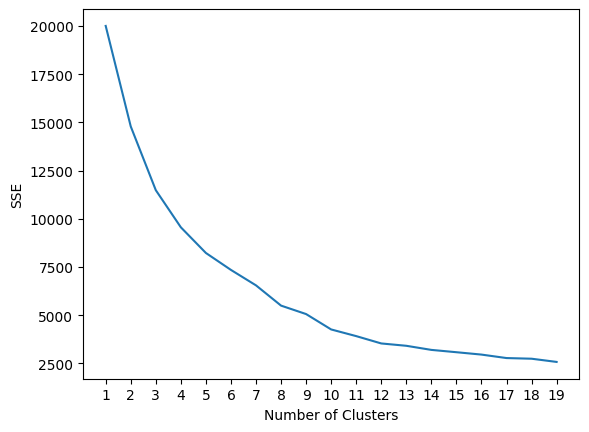

In [56]:
sse = []
for k in tqdm(range(1, 20)):
    kmeans = KMeans(n_clusters=k, init="random", n_init=10,max_iter=300,random_state=42)
    kmeans.fit(scaled_features1)
    sse.append(kmeans.inertia_)
    
plt.plot(range(1, 20), sse)
plt.xticks(range(1, 20))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [57]:
# Будем записывать значение коэффициента для каждого числа кластеров
silhouette_coefficients = []

for k in range(2, 20):
    kmeans = KMeans(n_clusters=k, init="random", n_init=10 ,max_iter=300,random_state=42)
    kmeans.fit(scaled_features1)
    score = silhouette_score(scaled_features1, kmeans.labels_)
    silhouette_coefficients.append(score)

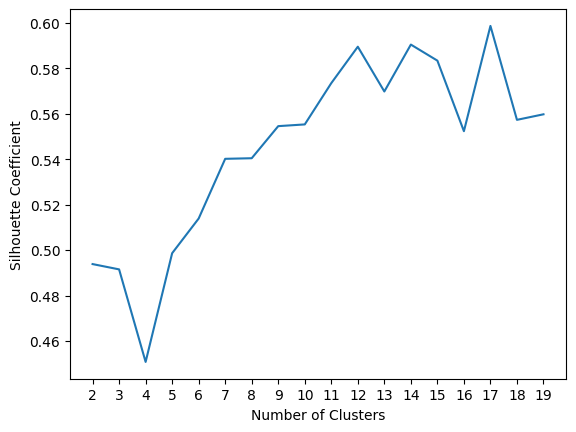

In [58]:
plt.plot(range(2, 20), silhouette_coefficients)
plt.xticks(range(2, 20))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

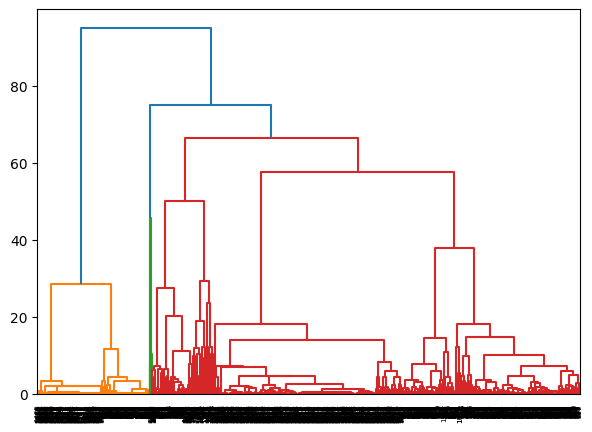

In [60]:
plt.figure(figsize=(7,5))
dend = sch.dendrogram(sch.linkage(scaled_features1, method='ward'))
plt.show()

#### Result: we can suggest that there are 5 clusters (one of them is outliers)

In [61]:
#инициализируем алгоритм
kmeans = KMeans(init="random",n_clusters=5,n_init=10,max_iter=300,random_state=42)
#применим алгоритм к нашим данным без названия 
kmeans.fit(scaled_features1)
print('The lowest SSE value: ', kmeans.inertia_)
print('Final locations of the centroid: ', kmeans.cluster_centers_)
print('Classes:', kmeans.labels_)


The lowest SSE value:  8224.20869473352
Final locations of the centroid:  [[-0.40354425 -0.99718706 -0.22943216 -0.25426526 -0.3266353  -0.40506527
  -0.63281226 -0.57978727 -0.06821845 -0.31448545]
 [ 0.27519573  0.53658537  0.07432536  0.1624099   0.14191387 -0.03911359
   0.05598019  0.031514    0.23487389  3.17979734]
 [ 0.51657909  0.99407407 -0.19450856 -0.15654579 -0.14514683 -0.4397038
  -0.33334458 -0.53276006  0.0089166  -0.31448545]
 [ 0.53917613  0.40740741  5.18877553  6.29056038  5.20905295 -3.08227913
  -0.19681955  1.31326831  3.86229164  1.75620065]
 [-0.28714132 -0.14420804  0.3360124   0.21269657  0.39312885  1.59441521
   1.58645505  1.72864126 -0.23715503 -0.31448545]]
Classes: [2 2 1 ... 0 0 4]


In [62]:
#инициализируем алгоритм
kmeans2 = KMeans(init="random",n_clusters=4,n_init=10,max_iter=300,random_state=42)
#применим алгоритм к нашим данным без названия 
kmeans2.fit(scaled_features1)
print('The lowest SSE value: ', kmeans2.inertia_)
print('Final locations of the centroid: ', kmeans2.cluster_centers_)
print('Classes:', kmeans2.labels_)


The lowest SSE value:  9555.57962840099
Final locations of the centroid:  [[-0.40756883 -0.99457259 -0.22401993 -0.24137334 -0.3248696  -0.40527291
  -0.63564325 -0.57806506 -0.06919498 -0.1912136 ]
 [ 0.43800253  0.35483871  4.82310199  5.86440898  4.8304425  -2.93461836
  -0.21079604  1.23929442  3.56540148  1.93989054]
 [-0.2767047  -0.09803922  0.33610758  0.21201872  0.39353887  1.5960493
   1.58350148  1.7304652  -0.20885813 -0.04042406]
 [ 0.53532679  0.99223803 -0.17941378 -0.13094582 -0.11765739 -0.44363173
  -0.32577417 -0.52609017  0.04700535  0.12851547]]
Classes: [3 3 3 ... 0 0 2]


In [63]:
df_main['financial_cluster_Kmeans']=kmeans.labels_
df['financial_cluster_Kmeans']=kmeans.labels_

<ipython-input-63-55a5a702a001>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_main['financial_cluster_Kmeans']=kmeans.labels_
<ipython-input-63-55a5a702a001>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['financial_cluster_Kmeans']=kmeans.labels_


In [64]:
df_main['financial_cluster_Kmeans2']=kmeans2.labels_
df['financial_cluster_Kmeans2']=kmeans2.labels_

<ipython-input-64-0c5d13e5da86>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_main['financial_cluster_Kmeans2']=kmeans2.labels_
<ipython-input-64-0c5d13e5da86>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['financial_cluster_Kmeans2']=kmeans2.labels_


## PCA 

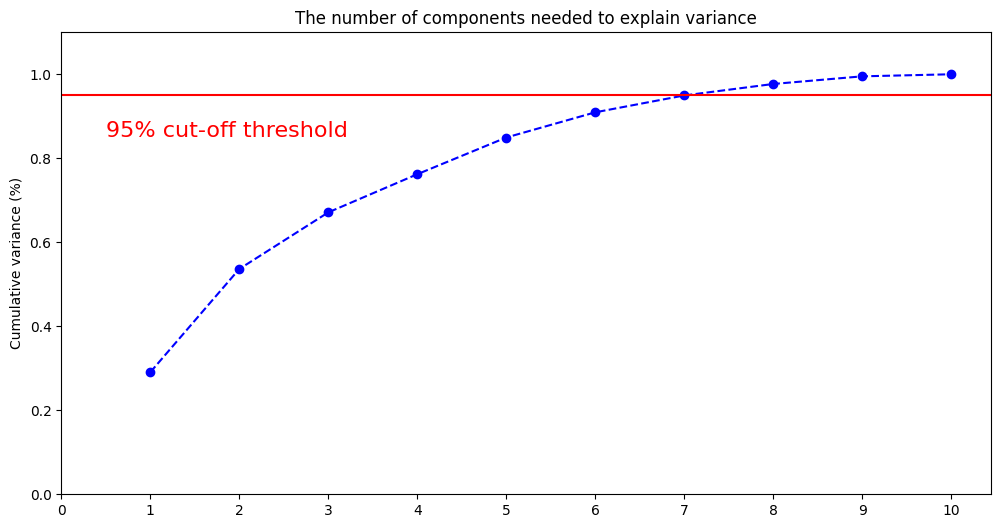

In [65]:
pca = PCA().fit(scaled_features1)
plt.rcParams["figure.figsize"] = (12,6)
fig, ax = plt.subplots()
xi = np.arange(1, 11, step=1)
y = np.cumsum(pca.explained_variance_ratio_)
plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')
plt.xticks(np.arange(0, 11, step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')
plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)
#ax.grid(axis='x')
plt.show()

In [66]:
pca = PCA(n_components = 0.95)
pca.fit(scaled_features1)
reduced = pca.transform(scaled_features1)
print('Original Dimensions: ',scaled_features1.shape)  
print('Reduced Dimensions: ',reduced.shape) 
x_pca=pca.transform(scaled_features1)

Original Dimensions:  (2000, 10)
Reduced Dimensions:  (2000, 8)


In [67]:
pca.explained_variance_ratio_

array([0.29054722, 0.24580653, 0.13481774, 0.09083023, 0.08743649,
       0.05999668, 0.04015086, 0.02732956])

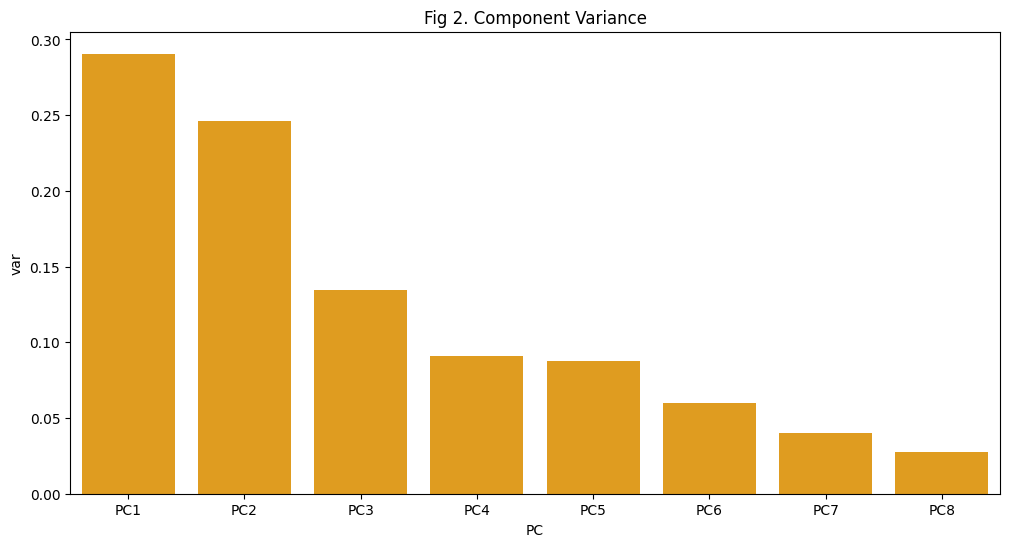

In [68]:
dfScree = pd.DataFrame({'var':pca.explained_variance_ratio_,'PC':['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8']})
sn.barplot(x='PC',y="var",data=dfScree, color="orange").set_title('Fig 2. Component Variance');

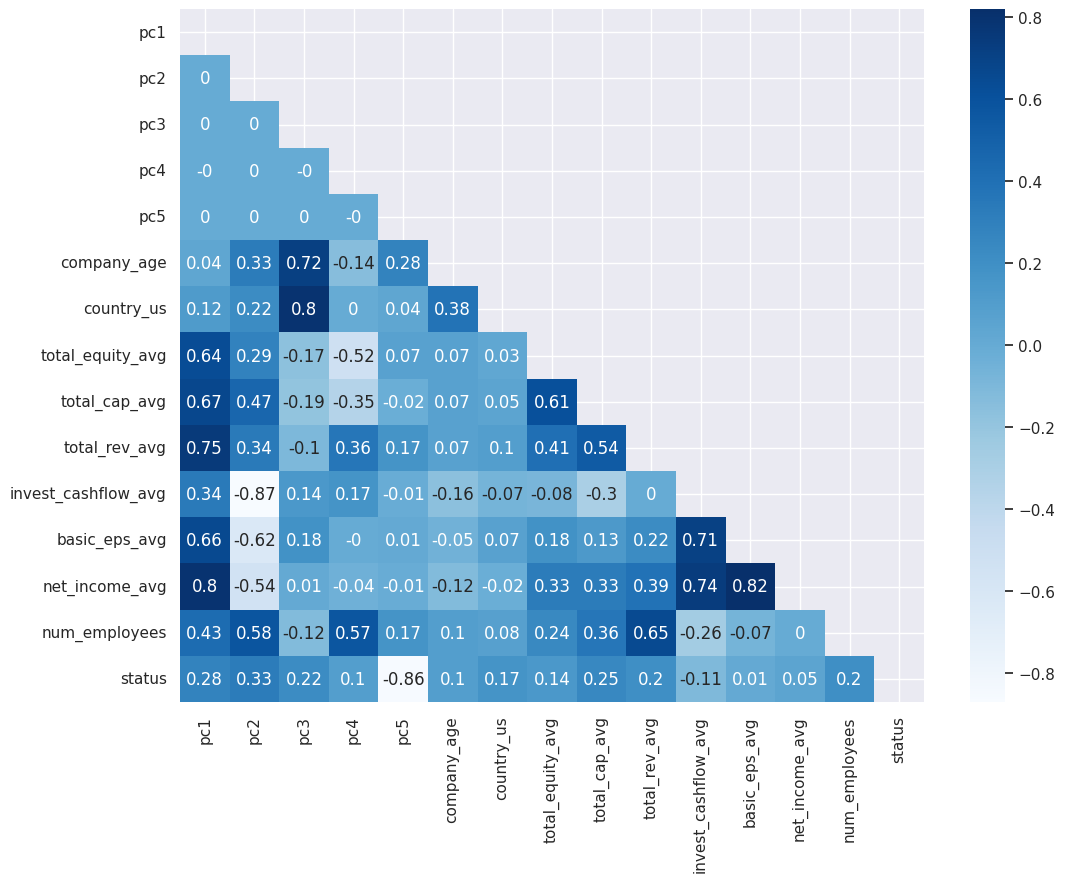

<Figure size 1200x900 with 0 Axes>

In [69]:
df_pc = pd.DataFrame(data = x_pca, columns = ['pc1','pc2','pc3','pc4','pc5','pc6','pc7','pc8'])
#df_pc=df_pc.drop(['pc5'],axis=1)
df_pc=df_pc.drop(['pc6'],axis=1)
df_pc=df_pc.drop(['pc7'],axis=1)
df_pc=df_pc.drop(['pc8'],axis=1)

scaled_features1 = StandardScaler().fit_transform(scaled_features1)
scaled_features1 = pd.DataFrame(scaled_features1, columns = features1.columns)

df_col = pd.concat([df_pc,features1], axis=1)
df_col
corrMatrix = pd.DataFrame.corr(df_col)
sn.set(rc={'figure.figsize':(12,9)})
upp_mat1 = np.triu(corrMatrix)
sn.heatmap(corrMatrix.round(2), annot=True, fmt='g',cmap = 'Blues', mask = upp_mat1)
plt.figure(figsize=(12,9))
plt.show()

In [ ]:

features = features1
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
fig = px.scatter(x_pca, x=1, y=2, color=df_main['financial_cluster_Kmeans'])

for i, feature in enumerate(features):
    fig.add_shape(
        type='line',
        x0=0, y0=0,
        x1=loadings[i, 0]*7,
        y1=loadings[i, 1]*7
    )
    fig.add_annotation(
        x=loadings[i, 0]*9,
        y=loadings[i, 1]*9,
        ax=0, ay=0,
        xanchor="center",
        yanchor="bottom",
        text=feature,
    )
fig.update_xaxes(title_text='PC 2')
fig.update_yaxes(title_text='PC 3')
plt.style.use('default')
fig.show()

In [ ]:
features = features1
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
fig = px.scatter(x_pca, x=0, y=4, color=df_main['financial_cluster_Kmeans'])
for i, feature in enumerate(features):
    fig.add_shape(
        type='line',
        x0=0, y0=0,
        x1=loadings[i, 0]*6,
        y1=loadings[i, 1]*6
    )
    fig.add_annotation(
        x=loadings[i, 0]*8,
        y=loadings[i, 1]*8,
        ax=0, ay=0,
        xanchor="center",
        yanchor="bottom",
        text=feature,
    )
fig.update_xaxes(title_text='PC 1')
fig.update_yaxes(title_text='PC 5')
fig.show()

**According to this graph purpel cluster will not invest in BC, while pink, yellow and blue ones ill implemet. Orange cluster can implement o not.**

## Agglomerative Clustering

In [ ]:
agglomerative = AgglomerativeClustering(n_clusters=5)
agglomerative.fit(scaled_features1)
df_main['financial_cluster_aggl']=agglomerative.labels_
df['financial_cluster_aggl']=agglomerative.labels_

C:\Users\garma\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\garma\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
agglomerative2 = AgglomerativeClustering(n_clusters=4)
agglomerative2.fit(scaled_features1)
df_main['financial_cluster_aggl2']=agglomerative2.labels_
df['financial_cluster_aggl2']=agglomerative2.labels_

C:\Users\garma\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\garma\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
features = features1
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
fig = px.scatter(x_pca, x=1, y=2, color=df_main['financial_cluster_aggl2'])

for i, feature in enumerate(features):
    fig.add_shape(
        type='line',
        x0=0, y0=0,
        x1=loadings[i, 0]*7,
        y1=loadings[i, 1]*7
    )
    fig.add_annotation(
        x=loadings[i, 0]*9,
        y=loadings[i, 1]*9,
        ax=0, ay=0,
        xanchor="center",
        yanchor="bottom",
        text=feature,
    )
fig.update_xaxes(title_text='PC 2')
fig.update_yaxes(title_text='PC 3')
fig.show()

In [ ]:
features = features1
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
fig = px.scatter(x_pca, x=0, y=4, color=df_main['financial_cluster_aggl2'])
for i, feature in enumerate(features):
    fig.add_shape(
        type='line',
        x0=0, y0=0,
        x1=loadings[i, 0]*6,
        y1=loadings[i, 1]*6
    )
    fig.add_annotation(
        x=loadings[i, 0]*8,
        y=loadings[i, 1]*8,
        ax=0, ay=0,
        xanchor="center",
        yanchor="bottom",
        text=feature,
    )
fig.update_xaxes(title_text='PC 1')
fig.update_yaxes(title_text='PC 5')
fig.show()

## DBSCAN

In [ ]:
dbscan = DBSCAN(min_samples=3)
dbscan.fit(scaled_features1)
df_main['financial_cluster_dbsc']=dbscan.labels_
df['financial_cluster_dbsc']=dbscan.labels_

C:\Users\garma\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\garma\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
kmeans_silhouette = silhouette_score(scaled_features1, kmeans.labels_).round(2)
agglomerative_silhouette = silhouette_score(scaled_features1, agglomerative.labels_).round(2)
dbscan_silhouette = silhouette_score(scaled_features1, dbscan.labels_).round(2)

kmeans_silhouette2 = silhouette_score(scaled_features1, kmeans2.labels_).round(2)
agglomerative_silhouette2 = silhouette_score(scaled_features1, agglomerative2.labels_).round(2)

In [ ]:
kmeans_silhouette  #5 clusters

0.5

In [ ]:
kmeans_silhouette2 #4 clusters

0.45

In [ ]:
agglomerative_silhouette #5 clusters

0.49

In [ ]:
agglomerative_silhouette2 #4 clusters

0.51

In [ ]:
dbscan_silhouette #5 clusters

0.42

### Result: K-means model is the best model that explains clusters for 63%. Finally, we got 5 clusters and 5 PCA.

In [ ]:
pd.pivot_table(df_main, index=['financial_cluster_aggl2'], values=[
 'company_age', 'country_us',
 'total_equity_avg',
 'total_cap_avg',
 'total_rev_avg',
 'invest_cashflow_avg',
 'basic_eps_avg',
 'net_income_avg',
 'num_employees',
 'status'], aggfunc=['mean'])

mean                         \
                        basic_eps_avg company_age country_us   
financial_cluster_aggl2                                        
0                            2.136747   50.258741   0.486266   
1                            3.598295   57.236715   0.708696   
2                            4.502179   64.300000   0.700000   
3                                 NaN   36.895161   0.423729   

                                                                           \
                        invest_cashflow_avg net_income_avg  num_employees   
financial_cluster_aggl2                                                     
0                                 -1.052842       0.690078   21240.014377   
1                                 -5.582487       5.003918   94891.311628   
2                                -78.157750      27.779445  581400.300000   
3                                       NaN            NaN   14190.327586   

                                                                                
                           status total_cap_avg total_equity_avg total_rev_avg  
financial_cluster_aggl2                                                         
0                        0.000000      9.756686         5.837480      7.842854  
1                        0.747826     58.086674        34.007049     51.404640  
2                        0.800000    453.916500       415.451797    190.374820  
3                        0.000000           NaN              NaN           NaN

In [ ]:
pd.pivot_table(df_main, values='status', index='financial_cluster_aggl2', aggfunc='count')

status
financial_cluster_aggl2        
0                          1347
1                           230
2                            10
3                           413

In [ ]:
df.to_excel('data_with_clusters.xlsx')

In [ ]:
df.to_excel('data_with_clusters2.xlsx')

## Results: 
**From two tables above we can see that 0 and 1 types mostly invests in BC, others 2 and 3 not:**

**0 type** is companies with high average age, but not sharks (100% of them are investing in BC).

**1st type** are sharks (with high average age on the market, investments, income, capitalization. 60% of them are investing in BC).

**2nd type** are the majority of companies which do not invest in BC at all.

**3rd type** has positive investments, they are younger, but can generate income even higher than sharks in average do (7% of them are investing in BC).


**NB! It is nessesary in PowerBI to look through the percentage of industry in each cluster and may be type of imlication.**

## Bootstrap

In [ ]:
# same function as bootstrap_kmeans defined later
scaled_features1 = StandardScaler().fit_transform(features1)
def bootstrap_hclust(n_clusters, n_samples=100):
    
    grouped_together = np.zeros((scaled_features1.shape[0], scaled_features1.shape[0]))
    counts = np.zeros((scaled_features1.shape[0], scaled_features1.shape[0]))
    
    for i in tqdm(range(n_samples)):
        indecies = np.random.choice(scaled_features1.shape[0], size=scaled_features1.shape[0], replace=True)
        Xb = scaled_features1[indecies, :]
        
        link = linkage(Xb, 'ward', 'euclidean')
        assigned_groups = fcluster(link, n_clusters, criterion='maxclust')
        
        for i_num, i in enumerate(indecies):
            for j_num, j in enumerate(indecies[i_num:]):
                counts[i, j] += 1
                if assigned_groups[i_num] == assigned_groups[i_num + j_num]:
                    grouped_together[i, j] += 1    
            
    return np.divide(grouped_together, counts, out=np.zeros_like(grouped_together), where = counts!=0)

In [ ]:
bootstrap_hclust_5 = bootstrap_hclust(n_clusters=5, n_samples=100)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [05:19<00:00,  3.20s/it]


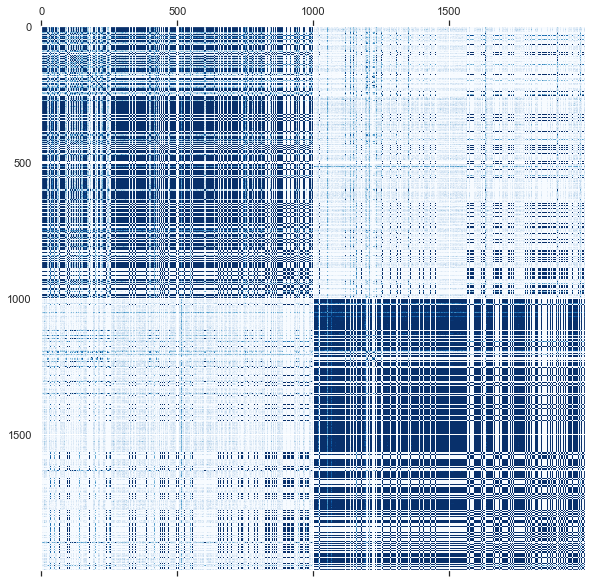

In [ ]:
fig, ax = plt.subplots(figsize=(16, 10))

ax.matshow(bootstrap_hclust_5, cmap=plt.cm.Blues)

In [ ]:
bootstrap_hclust_4 = bootstrap_hclust(n_clusters=4, n_samples=100)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [05:03<00:00,  3.04s/it]


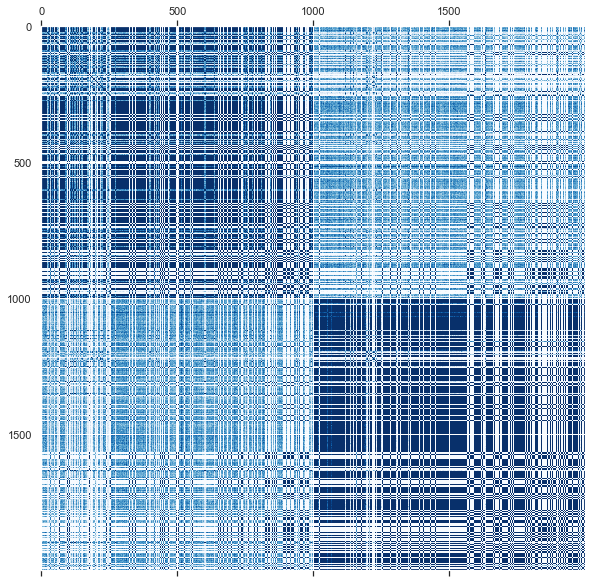

In [ ]:
fig, ax = plt.subplots(figsize=(16, 10))

ax.matshow(bootstrap_hclust_4, cmap=plt.cm.Blues)

## Logit model

We need to make a balanced data, because in our datacet only 10% firms implement BC (use upsampling method for minority data)

In [ ]:
rat = len(features1.loc[features1['status']==0])//len(features1.loc[features1['status']==1])
df_1 = features1.loc[features1['status']==1]
df_1 = df_1.loc[df_1.index.repeat(rat)]
train_n = pd.concat([features1.loc[features1['status']==0], df_1]).sample(frac=1)

In [ ]:
train_n['status'].value_counts()

0    1820
1    1800
Name: status, dtype: int64

In [ ]:
X = train_n.drop('status',axis=1)
y = train_n['status']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
y_train=y_train.astype('int')
y_test=y_test.astype('int')
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
LR = LogisticRegression(random_state=0, multi_class='ovr', max_iter=1000) #инициализация
LR.fit(X_train, y_train) #обучение

LogisticRegression(max_iter=1000, multi_class='ovr', random_state=0)

In [ ]:
print("Confusion matrix")
print(confusion_matrix(y_test, LR.predict(X_test)))
print('Precision: ', round(precision_score(y_test, LR.predict(X_test)), 3))
print('Recall: ', round(recall_score(y_test, LR.predict(X_test)), 3))
print('F-score: ', round(f1_score(y_test, LR.predict(X_test)), 3))
print('ACC: ', round(LR.score(X_test,y_test), 3))
print('AUC: ', round(roc_auc_score(y_test, LR.predict(X_test)), 3))

Confusion matrix
[[371  84]
 [253 197]]
Precision:  0.701
Recall:  0.438
F-score:  0.539
ACC:  0.628
AUC:  0.627
